In [1]:
import os
print(os.getcwd())

import torch
from torchvision import transforms

from src.manipulator._style_gan_manipulator.legacy import load_network_pkl

import matplotlib.pyplot as plt
plt.style.use('dark_background')
# ==== load StyleGAN's mapping and synthesis networks ====
# mapping: z -> w (shape: [1, latent_dim] -> [1, num_layers, 512])
# synthesis: takes per-layer w
# f = open("local_models/generators/imagenet128.pkl", "rb")

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device ", device)
ckpt_path = "../local_models/generators/stylegan2-ffhq-1024x1024.pkl"
# load generator
with open(ckpt_path, 'rb') as f:
    generator = load_network_pkl(f)['G_ema'].to(device)  # type: ignore

# generate latent vector and class label
z = torch.randn([1, generator.z_dim], device=device)

if generator.c_dim != 0:
    label = torch.zeros([1, generator.c_dim], device=device)

    target_class = 15  #  SELECT CLASS
    label[:, target_class] = 1
else:
    label = None



/tmp/pycharm_project_181
device  cuda


/tmp/pycharm_project_181/src/manipulator/_style_gan_manipulator/legacy.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_lo

Setting up PyTorch plugin "bias_act_plugin"... 

/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


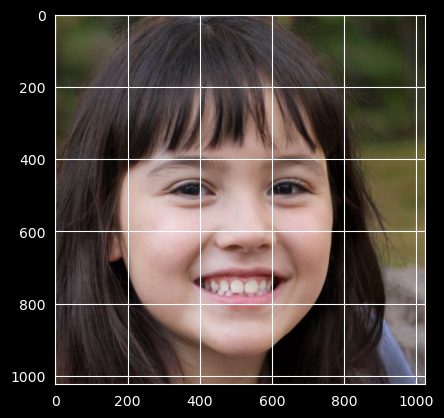

In [2]:
img_tensor = generator(z, label, truncation_psi=0.7, noise_mode='const')
img_tensor = (img_tensor.clamp(-1, 1) + 1) / 2  # normalize to [0, 1] ss
# save_image(img, 'stylegan_xl_sample.png')

img = img_tensor.cpu().detach().numpy()[0]
img = img.transpose(1, 2, 0)

plt.imshow(img)

Test segmentation model and classifiers

In [3]:
segementation_ckpt_path = "../local_models/segmentation/face_segmentation.pth"
# save_image(img, 'stylegan_xl_sample.png')

In [4]:
from local_models.segmentation.bisenet import BiSeNet
import torch.nn.functional as F
n_classes = 19
net = BiSeNet(n_classes=n_classes)
net.cuda()

net.load_state_dict(torch.load(segementation_ckpt_path))
net.eval()

preprocess = transforms.Compose([
    #transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
with torch.no_grad():
    # Assuming your input tensor is in shape [C, H, W] or [B, C, H, W]
    # If single image tensor (C,H,W), add batch dimension first
    if len(img_tensor.shape) == 3:
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension [1, C, H, W]

    # Resize
    resized_tensor = F.interpolate(img_tensor, size=(512, 512), mode='bilinear', align_corners=False)
    preprocess_tensor = preprocess(resized_tensor)
    out = net(preprocess_tensor)[0]
    out_max = out.argmax(dim=1)
    out_resize = F.interpolate(out_max.unsqueeze(0).float(), size=(1024, 1024), mode='nearest').squeeze().long()
    parsing = out_resize.squeeze(0).cpu().numpy()
    # print(parsing)
    print(np.unique(parsing))

[ 0  1  2  3  4  5  7 10 11 12 13 14 16 17]


/tmp/ipykernel_2144455/4118758042.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(segementation_ckpt_path))


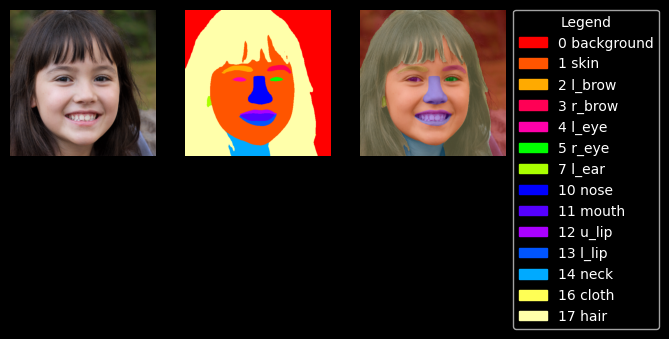

In [5]:
import matplotlib.patches as mpatches
# Colors for all 20 parts
part_colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0],
                   [255, 0, 85], [255, 0, 170],
                   [0, 255, 0], [85, 255, 0], [170, 255, 0],
                   [0, 255, 85], [0, 255, 170],
                   [0, 0, 255], [85, 0, 255], [170, 0, 255],
                   [0, 85, 255], [0, 170, 255],
                   [255, 255, 0], [255, 255, 85], [255, 255, 170],
                   [255, 0, 255], [255, 85, 255], [255, 170, 255],
                   [0, 255, 255], [85, 255, 255], [170, 255, 255]]

def overlay_segmentation_mask(parsing: np.ndarray):

    # Create a color mask using part_colors, where parsing values map to the respective colors
    color_mask = np.zeros((*parsing.shape, 3), dtype=np.uint8)  # Initialize color mask [H, W, 3]
    for class_idx, color in enumerate(part_colors):
        color_mask[parsing == class_idx] = color

    return color_mask

def add_legend(part_colors, labels):
    legend_patches = []
    for idx, color in enumerate(part_colors):
        if isinstance(labels, dict):
            if idx in np.unique(parsing):  # Ensure the label exists in celebamask_hq_labels
                label = str(idx) + " " + labels[idx]
                # Create a colored patch for the legend
                patch = mpatches.Patch(color=np.array(color) / 255.0, label=label)
                legend_patches.append(patch)
        elif isinstance(labels, list):
            if idx in np.unique(parsing):
                label = str(idx) + " " + labels[idx]
                # Create a colored patch for the legend
                patch = mpatches.Patch(color=np.array(color) / 255.0, label=label)
                legend_patches.append(patch)

    plt.legend(
        handles=legend_patches,
        bbox_to_anchor=(1.05, 1),  # Place the legend outside the plot
        loc='upper left',
        borderaxespad=0.,
        title="Legend"
    )

color_mask =overlay_segmentation_mask(parsing)

atts = ["background",'skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye', 'eye_g', 'l_ear',
        'r_ear', 'ear_r','nose', 'mouth', 'u_lip', 'l_lip', 'neck', 'neck_l', 'cloth',
        'hair', 'hat']

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(color_mask)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(color_mask, alpha=0.3)
plt.axis("off")
add_legend(part_colors, atts)

Test classifiers

In [ ]:
%%sql


In [6]:
from configs import sut_facial_path, preprocess_celeb_classifier
from src_.utils import load_facial_classifier

classifier = load_facial_classifier(sut_facial_path, device)
classifier(preprocess_celeb_classifier(img_tensor))[0,15]


/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(-7.3013, device='cuda:0', grad_fn=<SelectBackward0>)

In [7]:
classifier(img_tensor)[0][15]

tensor(-2.5318, device='cuda:0', grad_fn=<SelectBackward0>)

/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


(-0.5, 1023.5, 1023.5, -0.5)

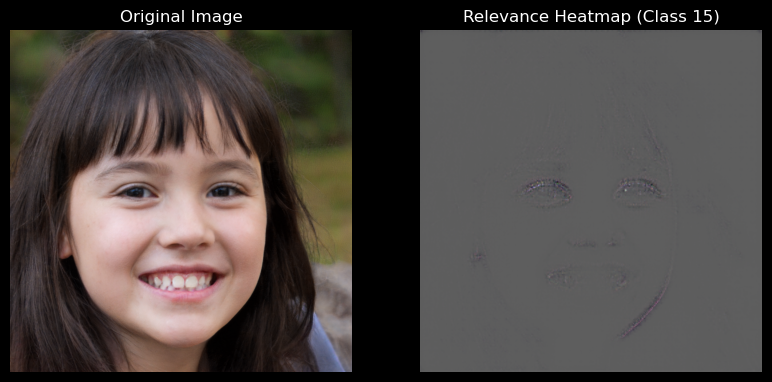

In [11]:
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient

# 创建一个one-hot编码的target，用于第15个logit
target_tensor = torch.zeros(1, 40, device=device)  # 假设分类器有1000个类别
target_tensor[0, 15] = 1  # 设置第15个logit为目标
canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)

with Gradient(model=classifier, composite=composite) as attributor:
    out, relevance = attributor(img_tensor, target_tensor)

relevance_np = relevance.cpu().detach().numpy()[0]
relevance_np = relevance_np.transpose(1, 2, 0)

# 归一化到[0,1]范围用于显示
relevance_vis = (relevance_np - relevance_np.min()) / (relevance_np.max() - relevance_np.min())

# 可视化结果
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(relevance_vis)
plt.title('Relevance Heatmap (Class 15)')
plt.axis("off")

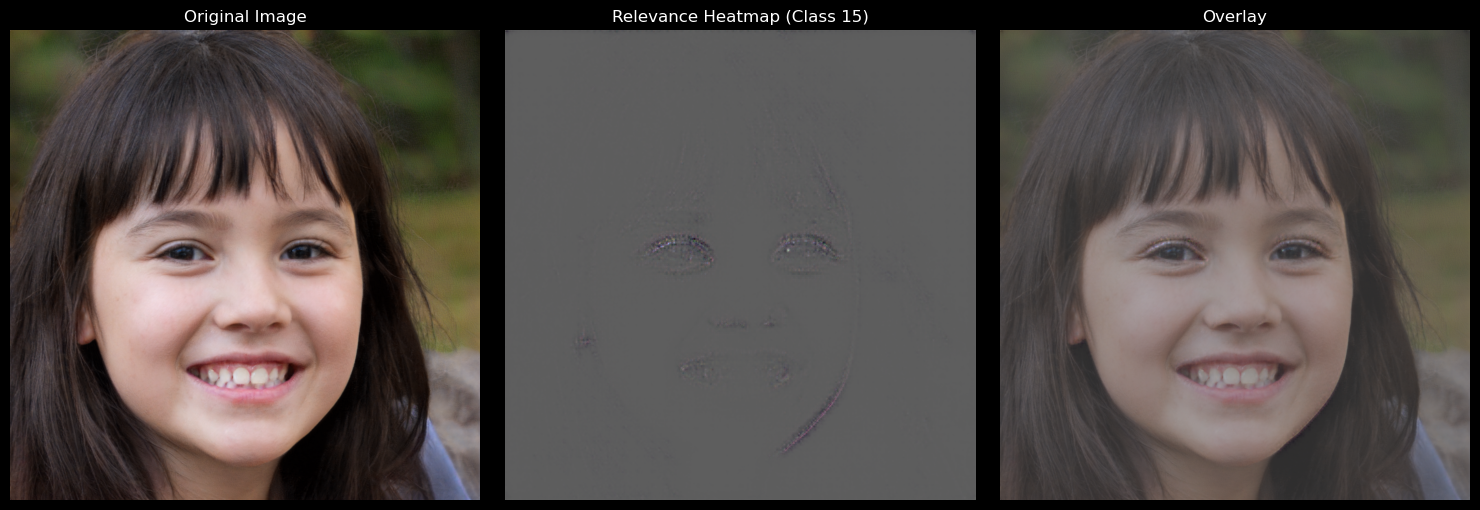

Classifier predicted score for class 15: -2.531665802001953


In [17]:
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient

# 创建一个one-hot编码的target，用于第15个logit
target_tensor = torch.zeros(1, 40, device=device)  # 根据分类器的类别数调整
target_tensor[0, 15] = 1  # 选取第15个类别作为logit目标

# 配置Canonizers和Composite，用于LRP
canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3.0, high=3.0, canonizers=canonizers)

# 使用 Gradient（zennit 框架内部可以配合 composite 来模仿 LRP 功能）
with Gradient(model=classifier, composite=composite) as attributor:
    out, relevance = attributor(img_tensor, target_tensor)

# 可视化 Relevance Map
relevance_np = relevance.cpu().detach().numpy()[0]
relevance_np = relevance_np.transpose(1, 2, 0)

# 归一化到[0, 1]显示
relevance_vis = (relevance_np - relevance_np.min()) / (relevance_np.max() - relevance_np.min())

# 显示结果
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(relevance_vis)
plt.title('Relevance Heatmap (Class 15)')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(relevance_vis, alpha=0.5)
plt.title('Overlay')
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Classifier predicted score for class 15: {out[0, 15].item()}")


In [18]:
relevance_vis

array([[[0.29133806, 0.29995725, 0.30197573],
        [0.37492344, 0.4074236 , 0.35601306],
        [0.31272745, 0.30692858, 0.32645878],
        ...,
        [0.37595168, 0.37454   , 0.36595044],
        [0.33129194, 0.32574263, 0.34189758],
        [0.3905942 , 0.38076746, 0.37153828]],

       [[0.3060567 , 0.29742652, 0.294701  ],
        [0.30650827, 0.2875516 , 0.29052818],
        [0.29689014, 0.2715186 , 0.31092405],
        ...,
        [0.35523832, 0.3462955 , 0.35002106],
        [0.3294701 , 0.33089417, 0.34919885],
        [0.34467542, 0.34651983, 0.3576935 ]],

       [[0.2655045 , 0.26736367, 0.28548798],
        [0.24677841, 0.2082591 , 0.25268567],
        [0.25597563, 0.21388136, 0.27866077],
        ...,
        [0.3560762 , 0.3372812 , 0.34382734],
        [0.3352058 , 0.34274694, 0.35608852],
        [0.31209528, 0.3181236 , 0.3408989 ]],

       ...,

       [[0.3548506 , 0.36166924, 0.3616771 ],
        [0.35474798, 0.3587719 , 0.3579182 ],
        [0.35904455, 0

In [9]:
from captum.attr import LRP
torch.cuda.empty_cache()
lrp = LRP(classifier)

attribution = lrp.attribute(img_tensor, target=15)
attribution_np = attribution.cpu().detach().numpy()[0]
attribution_np = attribution_np.transpose(1, 2, 0)
attribution_vis = (attribution_np - attribution_np.min()) / (attribution_np.max() - attribution_np.min())


/home/xchen/.conda/envs/stylegan3/lib/python3.9/site-packages/captum/attr/_core/lrp.py:207: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(input_tuple)


(-0.5, 1023.5, 1023.5, -0.5)

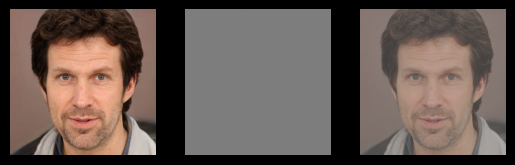

In [10]:
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(attribution_vis)
plt.axis("off")
plt.subplot(1, 3, 3)

plt.imshow(img)
plt.imshow(attribution_vis, alpha=0.5)
plt.axis("off")

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.34 GiB. GPU 0 has a total capacity of 10.90 GiB of which 2.25 GiB is free. Process 1399033 has 8.65 GiB memory in use. Of the allocated memory 8.44 GiB is allocated by PyTorch, and 35.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [16]:
attribution_np.max()

1.4615612e+26

In [18]:
attribution_np

array([[[ 2.35770898e+16, -1.78194396e+17, -1.29352286e+17],
        [-7.53316734e+16, -2.02921691e+17, -8.23204785e+16],
        [-1.32713510e+17, -7.82969789e+16,  2.85635855e+16],
        ...,
        [ 3.09243701e+16,  3.83763961e+16,  2.26458872e+16],
        [ 5.27220808e+16,  6.46706197e+16,  4.37632257e+16],
        [ 1.94446677e+16,  3.31743875e+16,  1.64181997e+16]],

       [[ 1.11330955e+17,  1.67886685e+16, -4.98646176e+16],
        [ 8.17653325e+15, -5.03158898e+16, -5.63340452e+16],
        [ 1.04590073e+17,  1.30451102e+17,  4.52794264e+16],
        ...,
        [-1.43445734e+16, -2.76615543e+16, -1.86500365e+16],
        [-2.73308010e+16, -2.84271688e+16, -3.25343665e+16],
        [ 1.13036592e+16,  2.51700803e+16, -1.38289558e+15]],

       [[ 2.35759882e+16,  6.02260114e+16,  3.14536690e+16],
        [-3.20316664e+16,  5.48507997e+16,  2.25172551e+16],
        [ 8.22860329e+16,  1.28286069e+17,  7.61669157e+16],
        ...,
        [ 6.76278249e+15, -3.46208187e+15,

In [10]:
from src_.occlusion import lrp_gradients_s_space,visualize_s_space_relevance
truncation_psi = 0.7
w = generator.mapping(z, None)
w = generator.mapping.w_avg + (w - generator.mapping.w_avg) * truncation_psi
s_relevance, classifier_output, img = lrp_gradients_s_space(
    generator.synthesis, classifier, preprocess, w,
    target_class=15, epsilon=1e-6, gamma=0.25
)

ImportError: cannot import name 'lrp_gradients_s_space' from 'RelevancePropagation' (/tmp/pycharm_project_181/RelevancePropagation.py)

In [8]:
print(classifier)

AttributeClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia